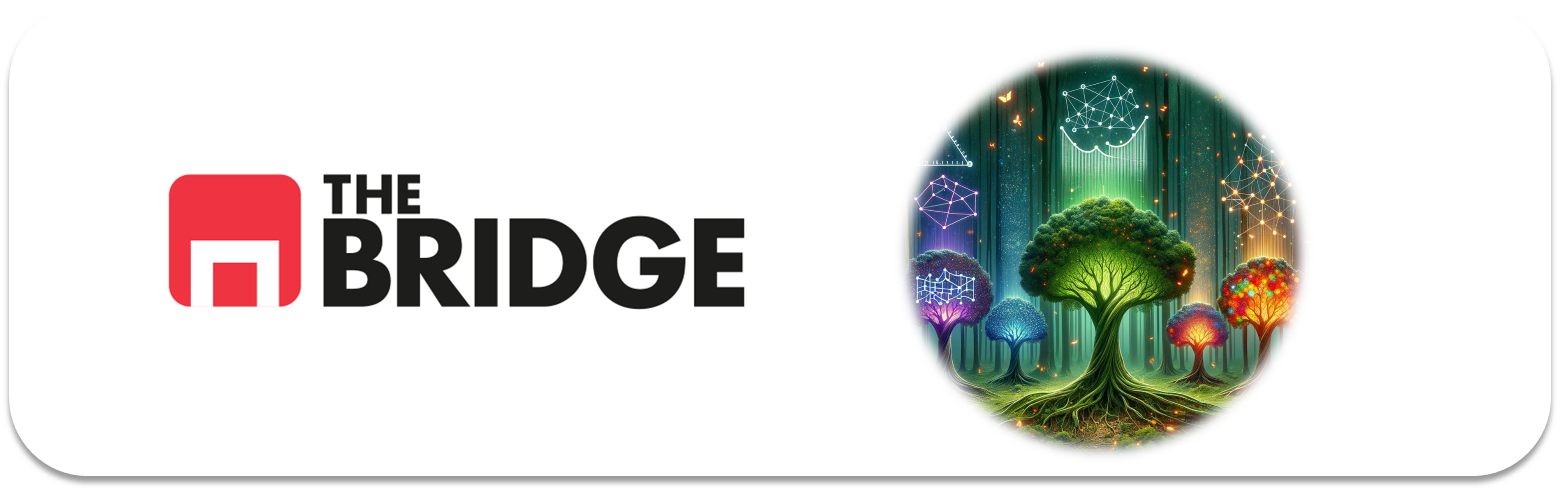

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [865]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Pintar
import bootcampviztools as bt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [866]:
# Cargamos el data set y por encima los datos
df = pd.read_csv('./data/bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


ANALISIS DEL SET

In [867]:
#Veamos si hay nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [868]:
# Comprobamos si hay duplicados
df.duplicated(keep = False).value_counts()

False    45211
Name: count, dtype: int64

In [869]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Resumen:
-No hay valores nulos, ni duplicados pero si hay variables que 
habrá que convertirlas antes de aplicar el modelo:
LABEL ENCODING
ONE-HOT ENCODING
ORDINAL ENCODING
BINARY ENCODING
FRECUENCY ENCODING
TARGET ENCODING
-Hay variables con rangos muy amplios, por lo que tendremos que escalar los datos para la parte de regresión logística

In [870]:
#Tratamiento del target
target = "y"
df[target].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

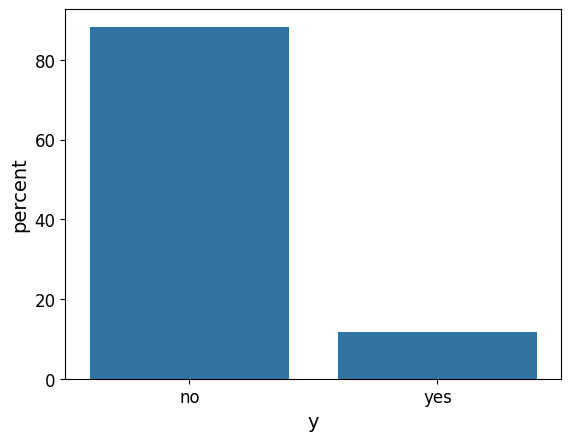

In [871]:
# Comprobamos la frecuencia de la variable target
sns.countplot(data=df, x="y", stat="percent");

Se puede observar que los datos de NO (85%) tienen más peso que SI (15%)
por lo que habría que tenerlo en cuenta a la hora de hacer el split entre train y test y estratificar. Se podría hacer por ejemplo un OVERSAMPLING, UNDERSAMPLING o SMOTE
Nota: Para el árbol de decisión no haría falta aplicar las técnicas de la línea superior, podemos usar el hiperparámetro "class_weight" = "balanced" para que lo trate directamente el algoritmo. El modelo de regresión logística sí que lo necesitaría pero para nuestro ejercicio no lo vamos a aplicar

In [872]:
#Variable definida con no o yes, vamos a pasarla a binario 0-1
df[target]=df[target].map({"yes":1, "no":0})

In [873]:
#Dividimos los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42) 
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]
X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

# Verificar las dimensiones de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36168, 16), (9043, 16), (36168,), (9043,))

In [874]:
# Comprobamos la frecuencia de "y" en los dataset de train y set, y así ver la estratificación 
train_set["y"].value_counts(normalize = True)

y
0    0.883931
1    0.116069
Name: proportion, dtype: float64

Como ya habiamos observado, en el set de train hay muchos valores de No y pocos de Si, por lo que ha quedado desbalanceado con relación a los 1.

In [875]:
#Una vez bien definida la variable target, vamos a dividir el dataset con X e Y
X= df.drop(columns=[target])
y=df[target]

MINI EDA

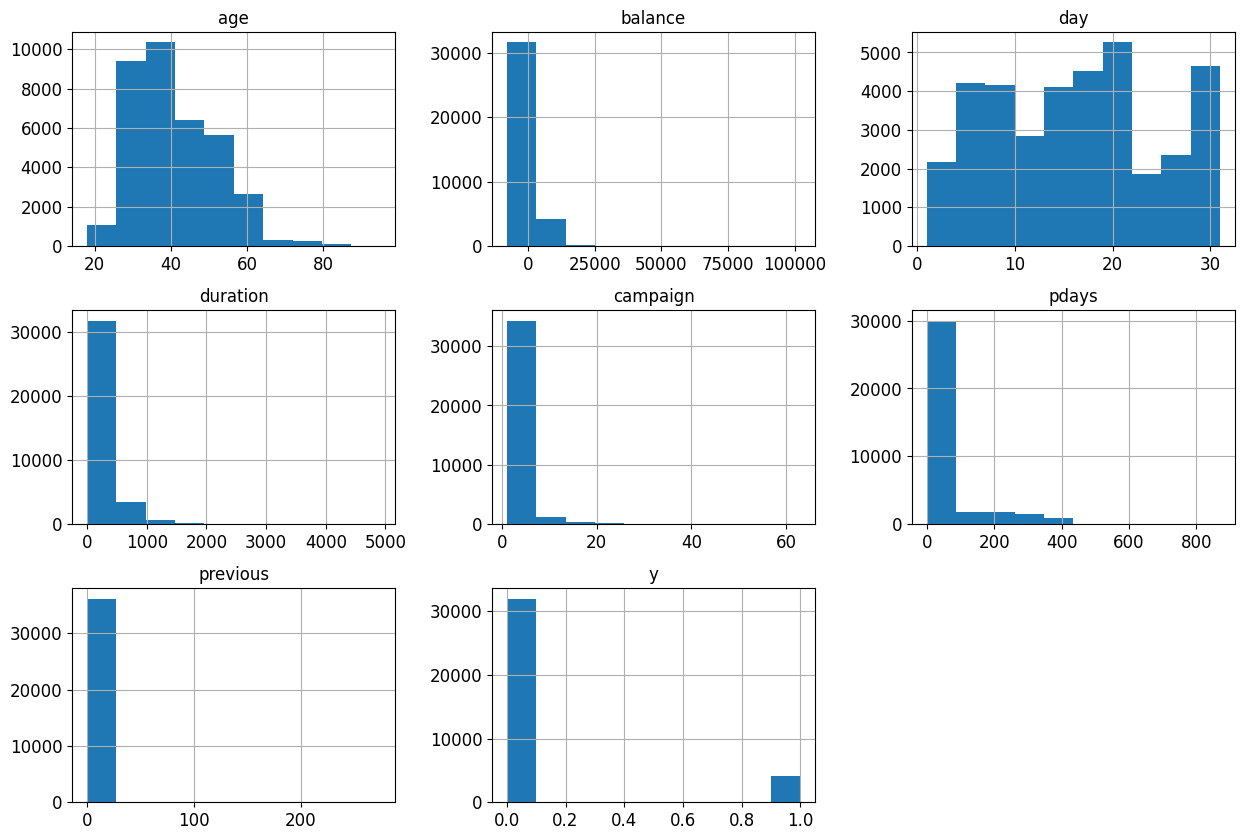

In [876]:
train_set.hist(figsize=(15, 10));

In [877]:
#Variables categóricas
features_cat = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

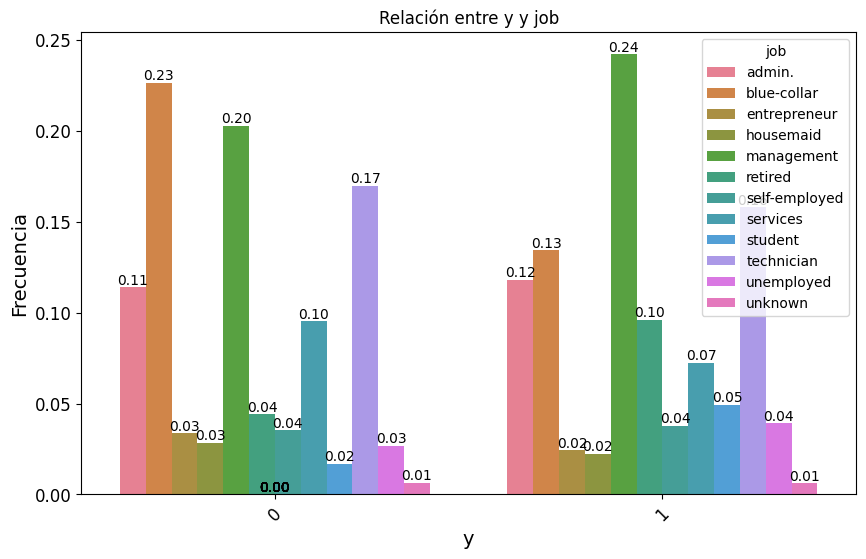

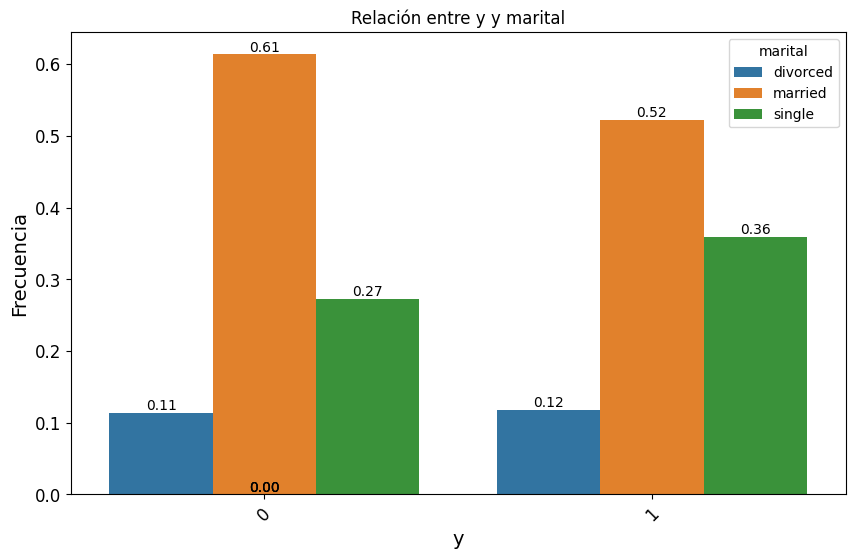

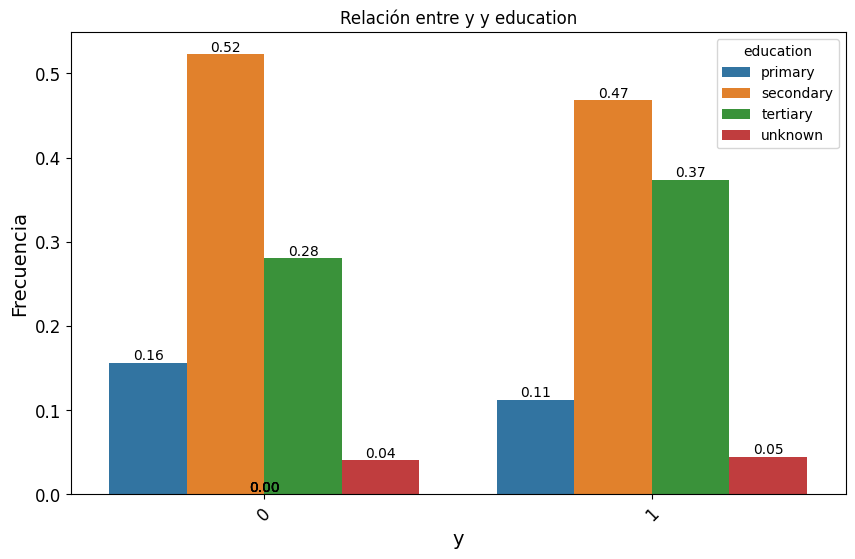

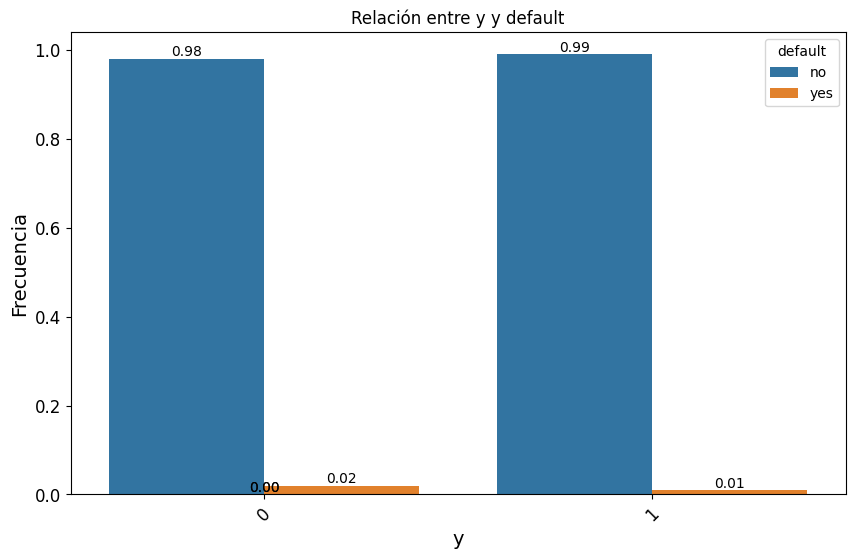

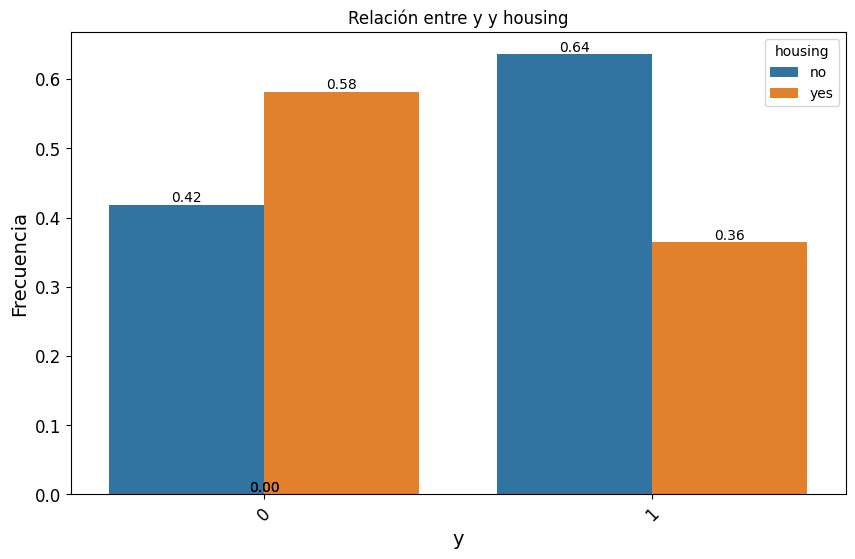

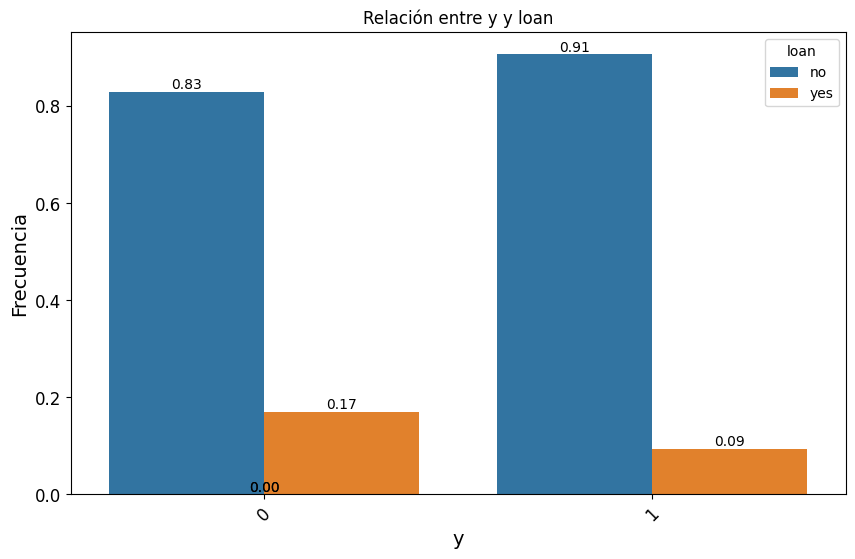

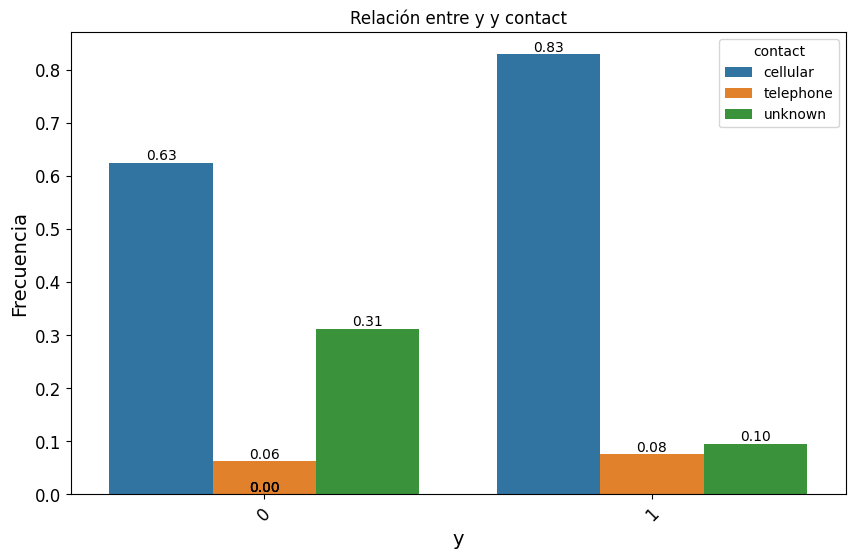

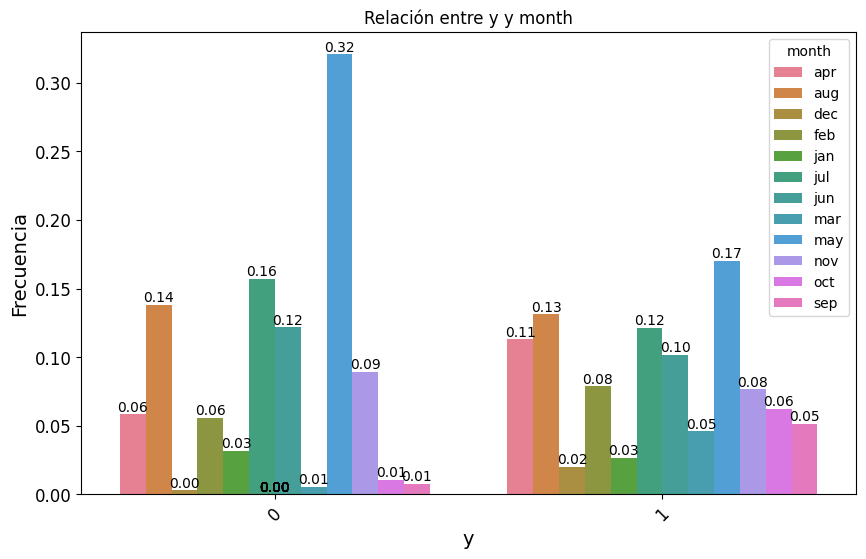

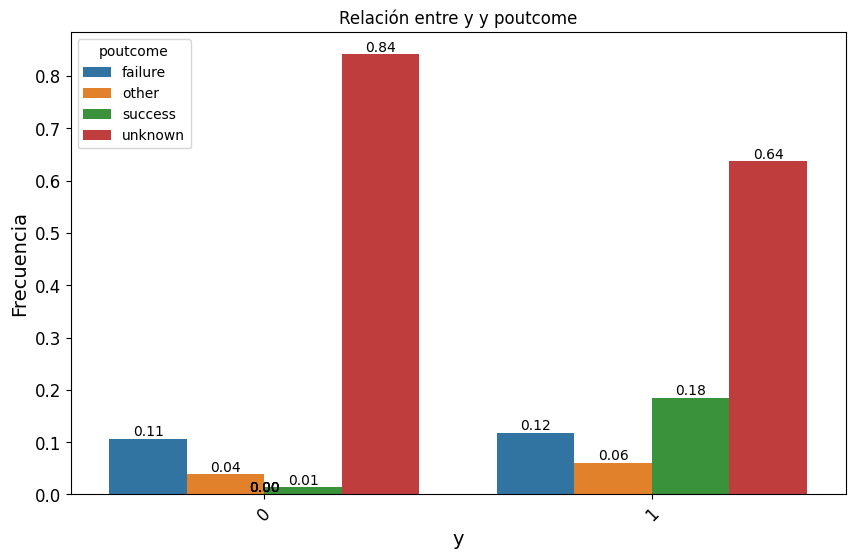

In [878]:
#Analisis visual
for feat in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, feat, show_values= True, relative_freq= True)


In [879]:
#Eliminamos las variables que vemos que no tienen relación
features_cat.remove("marital")
features_cat.remove("education")
features_cat.remove("default")
features_cat.remove("loan")
print(features_cat)

['job', 'housing', 'contact', 'month', 'poutcome']


In [880]:
#Variables numéricas
features_num = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

In [881]:
#guardamos el set
bck_train_0 = train_set.copy()

In [882]:
from sklearn.preprocessing import LabelEncoder

label_encoder_y = LabelEncoder()

label_encoder_y.fit(train_set["y"])
train_set["y"] = label_encoder_y.transform(train_set["y"])

y = train_set["y"]

In [883]:
corr_matrix = train_set.corr(numeric_only= True)
corr_matrix_abs = corr_matrix["y"].abs().sort_values(ascending = False)
corr_matrix_abs

y           1.000000
duration    0.393402
pdays       0.105742
previous    0.092051
campaign    0.072571
balance     0.052518
age         0.026684
day         0.025887
Name: y, dtype: float64

In [884]:
# Fijamos un criterio para seleccionar nuestras features numéricas
criterio = 0.1
features_num = corr_matrix_abs[corr_matrix_abs > criterio].index.to_list()
features_num.remove(target) # Quitamos el target
print(features_num)

['duration', 'pdays']


In [885]:
# Comprobamos la colinealidad

criterio_col = 0.7
excluidas = []
corr_numeric = train_set[features_num].corr(numeric_only = True)

for col in features_num:
    print(f"Comprobando colinealidad de {col}")
    if col not in excluidas:
        for col_2, valor_corr in corr_numeric[col].items():
            print(f"\tComprobando {col} con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"\t\t--> {col} correla con {col_2} al {valor_corr:0.4f}, EXCLUIMOS {col_2} <--")
                    excluidas.append(col_2)
                else:
                    print(f"\t\t{col} correla con {col_2} al {valor_corr:0.4f}, mantenemos {col_2}")
            elif col == col_2:
                print("\t\tSon la misma variable, no comprobamos")
    
    elif col in excluidas:
        print(f"\tLa columna {col} ya ha sido excluida")

excluidas = list(set(excluidas))
print("\nLas variables a excluir son", excluidas)

Comprobando colinealidad de duration
	Comprobando duration con duration
		Son la misma variable, no comprobamos
	Comprobando duration con pdays
		duration correla con pdays al -0.0012, mantenemos pdays
Comprobando colinealidad de pdays
	Comprobando pdays con duration
		pdays correla con duration al -0.0012, mantenemos duration
	Comprobando pdays con pdays
		Son la misma variable, no comprobamos

Las variables a excluir son []


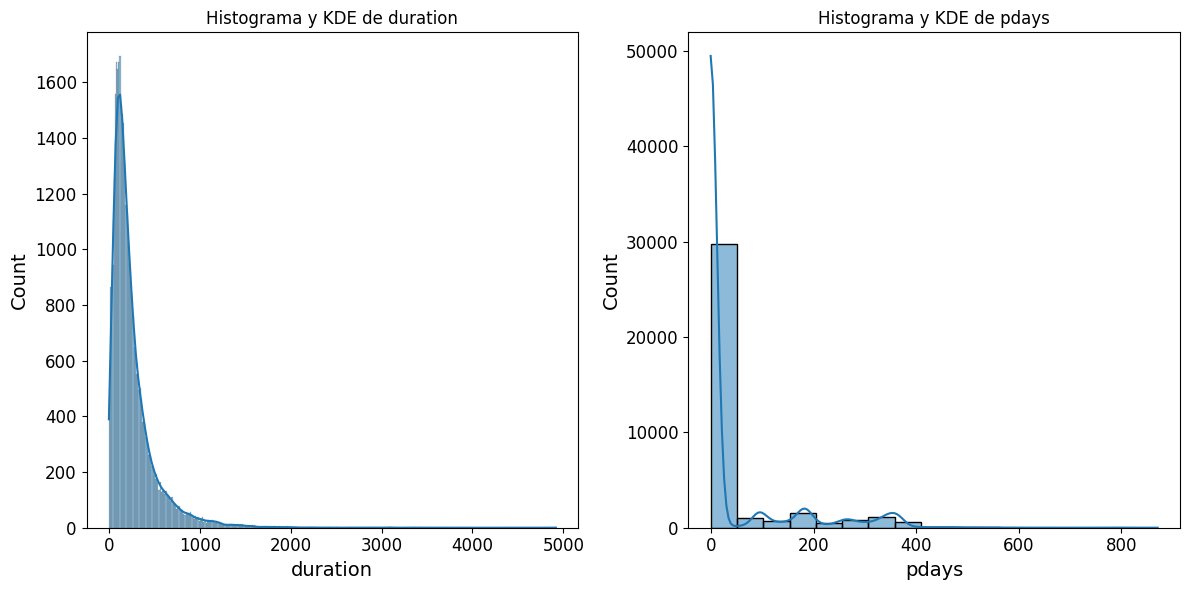

In [886]:
#Veamos como son graficamente

def plot_histo_den(df, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_histo_den(train_set, features_num)

In [887]:
#Se observa que tiene valores menosres o iguales a , no hay que aplicar log

In [888]:
train_set.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.930823,1361.046146,15.817739,256.891202,2.765649,40.180076,0.580264,0.116069
std,10.618369,3023.083187,8.325860,256.884103,3.120193,100.107617,2.370668,0.320313
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,70.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,447.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1429.000000,21.000000,318.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [889]:
bck_train_1 = train_set.copy()
train_set = bck_train_1

Definición del train tras el EDA

In [890]:
#Feautures de nuestro modelo
features_all = features_num + features_cat # Estas son las variables que vamos a usar en nuestro modelo
features_all

['duration', 'pdays', 'job', 'housing', 'contact', 'month', 'poutcome']

In [891]:
df_dummies = pd.get_dummies(df[features_all], columns=features_cat, drop_first=True)


In [892]:
train_set = train_set[features_all]

In [893]:
# Convertimos las variables categóricas que nos quedan en variables numéricas
# Crear dummies solo para estas variables
label_encoder_job = LabelEncoder()
label_encoder_housing = LabelEncoder()
label_encoder_contact = LabelEncoder()
label_encoder_poutcome = LabelEncoder()

label_encoder_job.fit(train_set["job"])
train_set["job"] = label_encoder_job.transform(train_set["job"])

label_encoder_housing.fit(train_set["housing"])
train_set["housing"] = label_encoder_housing.transform(train_set["housing"])

label_encoder_contact.fit(train_set["contact"])
train_set["contact"] = label_encoder_contact.transform(train_set["contact"])

label_encoder_poutcome.fit(train_set["poutcome"])
train_set["poutcome"] = label_encoder_poutcome.transform(train_set["poutcome"])

C:\Users\Carol\AppData\Local\Temp\ipykernel_23544\550045827.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["job"] = label_encoder_job.transform(train_set["job"])
C:\Users\Carol\AppData\Local\Temp\ipykernel_23544\550045827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["housing"] = label_encoder_housing.transform(train_set["housing"])
C:\Users\Carol\AppData\Local\Temp\ipykernel_23544\550045827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [894]:
#Tratamos la variable month
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder_month = OrdinalEncoder()

ordinal_encoder_month.fit(train_set[["month"]])
train_set["month"] = ordinal_encoder_month.transform(train_set[["month"]])

C:\Users\Carol\AppData\Local\Temp\ipykernel_23544\3132936871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["month"] = ordinal_encoder_month.transform(train_set[["month"]])


In [895]:
# Escalamos las numéricas

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_set[features]) 

StandardScaler()

In [896]:
# Aplico escalado a ambos sets, train y test

train_set[features] = scaler.transform(train_set[features])

C:\Users\Carol\AppData\Local\Temp\ipykernel_23544\531070408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[features] = scaler.transform(train_set[features])


In [897]:

train_set.describe()

,duration,pdays,job,housing,contact,month,poutcome
count,3.616800e+04,3.616800e+04,3.616800e+04,3.616800e+04,3.616800e+04,3.616800e+04,3.616800e+04
mean,3.187502e-17,-2.848615e-17,-1.694435e-17,-1.768106e-18,-6.286598e-17,7.710905e-17,-5.834749e-17
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.000041e+00,-4.113638e-01,-1.326053e+00,-1.120646e+00,-7.114620e-01,-1.838937e+00,-2.591074e+00
25%,-5.990769e-01,-4.113638e-01,-1.020575e+00,-1.120646e+00,-7.114620e-01,-8.401482e-01,4.451140e-01
50%,-2.993267e-01,-4.113638e-01,-1.041403e-01,8.923425e-01,-7.114620e-01,1.586405e-01,4.451140e-01
75%,2.378880e-01,-4.113638e-01,8.122941e-01,8.923425e-01,1.517492e+00,8.244996e-01,4.451140e-01
max,1.814504e+01,8.299383e+00,2.034207e+00,8.923425e-01,1.517492e+00,1.823288e+00,4.451140e-01


Ahora hacemos lo mismo pero al test_Set

In [898]:
test_set["y"] = label_encoder_y.transform(test_set["y"])
y_test = test_set[target]
test_set = test_set[features_all]
test_set["job"] = label_encoder_job.transform(test_set["job"])
test_set["housing"] = label_encoder_housing.transform(test_set["housing"])
test_set["contact"] = label_encoder_contact.transform(test_set["contact"])
test_set["poutcome"] = label_encoder_poutcome.transform(test_set["poutcome"])
test_set["month"] = ordinal_encoder_month.transform(test_set[["month"]])
test_set[features_all] = scaler.transform(test_set[features_all])
X_test = test_set

Modelos

In [899]:
bck_train_2 = train_set.copy()
train_set = bck_train_2

In [900]:
# Ahora creamos las variables X,y para los datos de entrenamiento tras todo el trabajo previo

X = train_set.copy()
y = y

In [901]:
# Creamos el modelo de regresión logística

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000)
clf.fit(X,y)

LogisticRegression(max_iter=10000)

Árboles de decisión

In [902]:
# Creamos el modelo de árboles de decisión sin optimizar hiperparámetros

tree_clf_sin_opt = DecisionTreeClassifier(max_depth=2,
                                  random_state=42, class_weight="balanced")
tree_clf_sin_opt.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

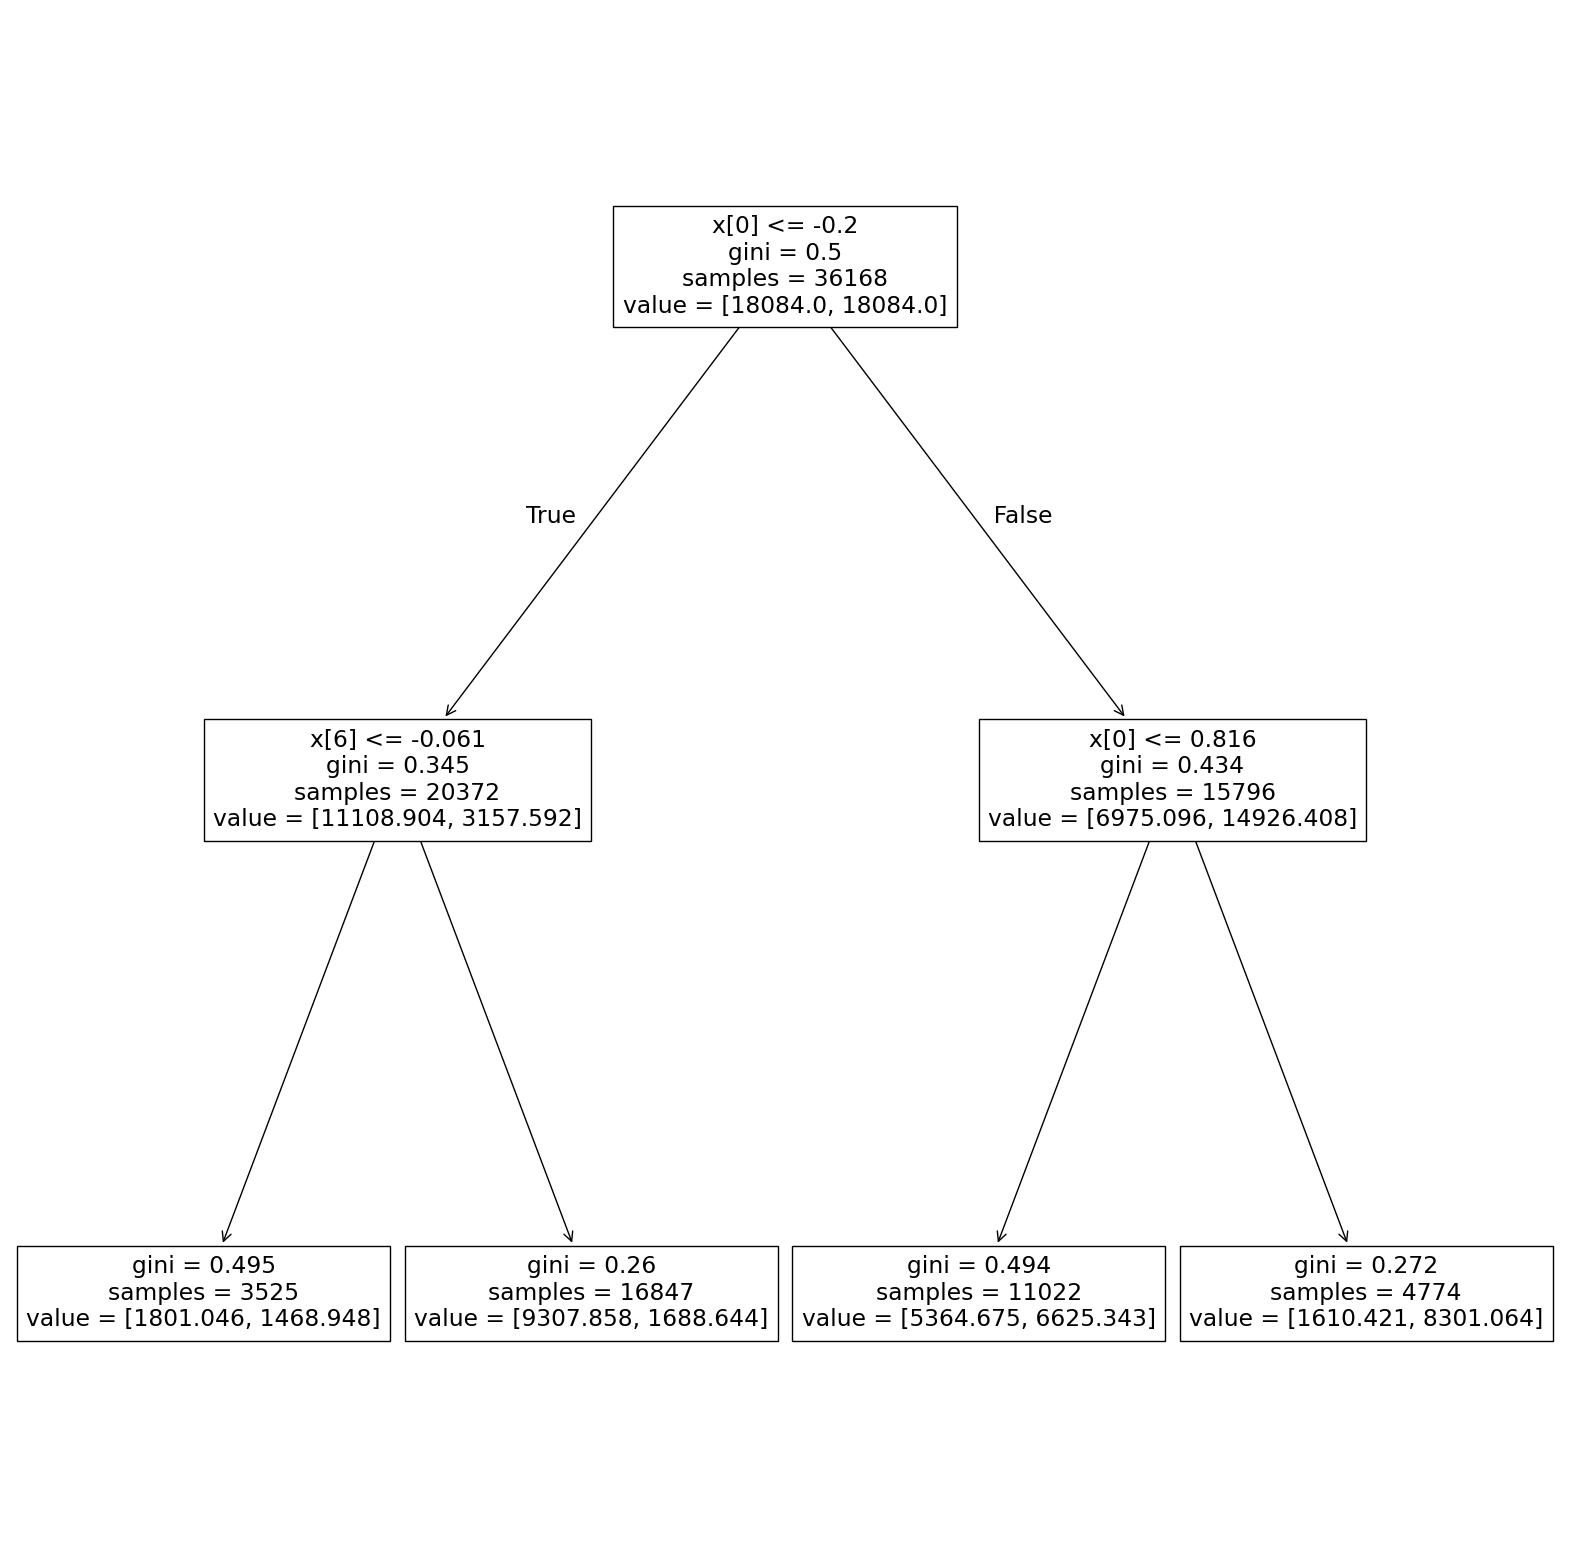

In [903]:
# Pintamos

from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(tree_clf_sin_opt);

In [904]:
# Crear y entrenar el modelo de árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [905]:
# Evaluar el modelo de árbol de decisión
tree_predictions = tree_model.predict(X_test)
tree_mae = mean_absolute_error(y_test, tree_predictions)
tree_mse = mean_squared_error(y_test, tree_predictions)
print(f'Decision Tree MAE: {tree_mae}')
print(f'Decision Tree MSE: {tree_mse}')


Decision Tree MAE: 0.1343224347868824
Decision Tree MSE: 0.13191952577739005


In [906]:

# Evaluar el modelo de árbol de decisión
tree_predictions = tree_model.predict(X_test)
tree_mae = mean_absolute_error(y_test, tree_predictions)
tree_mse = mean_squared_error(y_test, tree_predictions)
print(f'Decision Tree MAE: {tree_mae}')
print(f'Decision Tree MSE: {tree_mse}')

Decision Tree MAE: 0.1343224347868824
Decision Tree MSE: 0.13191952577739005
